In [1]:
import random as rd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error #, r2_score
from sklearn.model_selection import train_test_split

import gspread
from sqlalchemy import create_engine
import re

gc = gspread.service_account(filename="./credentials.json")

import environ
env = environ.Env()
database_url = env.str(
    var="DATABASE_URL", default="postgres://postgres:@postgres:5432/postgres"
)
engine = create_engine(database_url, echo=False)

In [2]:
data = pd.read_sql("marketing_lead", engine)
data['week'] = data['date'].dt.isocalendar().week
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data = data[data['status'] == 'WIN']
feature = ['status', 'week','month', 'year']
cl_data = data[feature]
by_data = cl_data.groupby(['year','month', 'week']).agg(['count'])
by_data

status
                 count
year month week       
2020 10    42        1
     11    44        2
           45        7
           46        1
           47        4
           48        4
           49        1
     12    49        3
           50        2
           51        5
           52        1
           53        1
2021 1     1        30
           2        33
           3        19
           4        21
     2     5        16
           6        14
           7        17
           8        10
     3     9        14
           10       14
           11       12

In [3]:
re_data = by_data.reset_index()
re_data = re_data[re_data['week'] > 2]
# re_data['index_week'] = [i + 1 for i in range(len(re_data[['week']]))]
re_data.set_index(['year', 'month'])

week status
                 count
year month            
2020 10      42      1
     11      44      2
     11      45      7
     11      46      1
     11      47      4
     11      48      4
     11      49      1
     12      49      3
     12      50      2
     12      51      5
     12      52      1
     12      53      1
2021 1        3     19
     1        4     21
     2        5     16
     2        6     14
     2        7     17
     2        8     10
     3        9     14
     3       10     14
     3       11     12

In [4]:
spent_fb = pd.read_sql("etl_marketing_facebook", engine)
spent_fb = spent_fb[spent_fb['type'] == 'daily']
feature_fb = ['clicks', 'impressions', 'spend', 'date_start']

spent_fb = spent_fb[feature_fb]
spent_fb['date'] = pd.to_datetime(spent_fb['date_start'])

spent_fb['spend'] = spent_fb['spend'].astype(float)
spent_fb['clicks'] = spent_fb['clicks'].astype(float)
spent_fb['impressions'] = spent_fb['impressions'].astype(float)
spent_fb['week'] = spent_fb['date'].dt.isocalendar().week
spent_fb['month'] = spent_fb['date'].dt.month
spent_fb['year'] = spent_fb['date'].dt.year
spent_fb = spent_fb[['spend', 'clicks', 'impressions', 'week', 'month', 'year']]


In [5]:
by_fb = spent_fb.groupby(['year','month', 'week']).agg(['sum'])
re_fb = by_fb.reset_index()
re_fb = re_fb[re_fb['week'] > 2]
re_fb = re_fb[['week', 'spend', 'clicks', 'impressions',]]
re_fb

,week,spend,clicks,impressions
,,sum,sum,sum
0,40,438.04,218.0,2820.0
1,41,898.49,101.0,19548.0
2,42,1950.53,158.0,49977.0
3,43,870.93,381.0,31956.0
4,44,1131.68,475.0,44948.0
5,45,1380.95,336.0,7352.0
6,46,1501.54,370.0,10511.0
7,47,1585.33,420.0,14264.0
8,48,1693.97,1637.0,41693.0


In [6]:
mr_data = re_data.merge(re_fb, on='week', suffixes=('_lead', '_fb'))
mr_data = mr_data.rename(columns={'spend': 'Cost'})
mr_data1 = mr_data
mr_data

/usr/local/lib/python3.8/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,year,month,week,status,Cost,clicks,impressions
,,,,count,sum,sum,sum
0,2020,10,42,1,1950.53,158.0,49977.0
1,2020,11,44,2,1131.68,475.0,44948.0
2,2020,11,45,7,1380.95,336.0,7352.0
3,2020,11,46,1,1501.54,370.0,10511.0
4,2020,11,47,4,1585.33,420.0,14264.0
5,2020,11,48,4,1693.97,1637.0,41693.0
6,2020,11,49,1,290.48,182.0,3659.0
7,2020,11,49,1,3678.65,2715.0,58950.0
8,2020,12,49,3,290.48,182.0,3659.0


In [7]:
gg_data = pd.read_sql("etl_google_ads", engine)

gg_data['Cost'] = gg_data['Cost'].astype(float)
gg_data['clicks'] = gg_data['clicks'].astype(float)
gg_data['impressions'] = gg_data['impressions'].astype(float)
gg_data = gg_data.query('Cost != 0 and Cost < 200 and impressions <= 250 and clicks > 0')

In [8]:
gg_data['Date'] = pd.to_datetime(gg_data['Date'])

gg_data['week'] = gg_data['Date'].dt.isocalendar().week
gg_data['month'] = gg_data['Date'].dt.month
gg_data['year'] = gg_data['Date'].dt.year
gg_data = gg_data[['Cost', 'clicks', 'impressions', 'week', 'month', 'year']]


In [9]:
by_gg = gg_data.groupby(['year','month', 'week']).agg(['sum'])
re_gg = by_gg.reset_index()
re_gg = re_gg[['week', 'Cost', 'clicks', 'impressions']]
re_gg

,week,Cost,clicks,impressions
,,sum,sum,sum
0,45,680.49,69.0,652.0
1,46,937.25,111.0,1386.0
2,47,527.09,90.0,1013.0
3,48,851.87,142.0,1446.0
4,49,86.14,9.0,56.0
5,49,570.11,100.0,955.0
6,51,524.85,58.0,460.0
7,52,861.65,180.0,2025.0
8,1,516.92,49.0,512.0


In [10]:
cc_data = pd.concat([mr_data1, re_gg]).groupby(['year','month', 'week']).sum().reset_index()
cc_data

/usr/local/lib/python3.8/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,year,month,week,Cost,clicks,impressions,status
,,,,sum,sum,sum,count
0,2020.0,10.0,42,1950.53,158.0,49977.0,1.0
1,2020.0,11.0,44,1131.68,475.0,44948.0,2.0
2,2020.0,11.0,45,1380.95,336.0,7352.0,7.0
3,2020.0,11.0,46,1501.54,370.0,10511.0,1.0
4,2020.0,11.0,47,1585.33,420.0,14264.0,4.0
5,2020.0,11.0,48,1693.97,1637.0,41693.0,4.0
6,2020.0,11.0,49,3969.13,2897.0,62609.0,2.0
7,2020.0,12.0,49,3969.13,2897.0,62609.0,6.0
8,2020.0,12.0,50,2468.21,1638.0,53512.0,2.0


In [11]:
# mr_data = mr_data.merge(re_gg, on='week', suffixes=('_fb', '_gg'))
# mr_data

In [12]:
# cc_data['sum_cost'] = cc_data.loc[:, ['spend', 'Cost']].sum(axis=1)
# rename_data = cc_data.rename(columns={'spend': 'cost_fb', 'Cost':'cost_gg'})
data_clear = cc_data[['week','status', 'Cost', 'clicks','impressions']]
data_clear['status'] = data_clear['status'].astype(int)
data_clear

<ipython-input-12-02259a6484a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clear['status'] = data_clear['status'].astype(int)


,week,status,Cost,clicks,impressions
,,count,sum,sum,sum
0,42,1,1950.53,158.0,49977.0
1,44,2,1131.68,475.0,44948.0
2,45,7,1380.95,336.0,7352.0
3,46,1,1501.54,370.0,10511.0
4,47,4,1585.33,420.0,14264.0
5,48,4,1693.97,1637.0,41693.0
6,49,2,3969.13,2897.0,62609.0
7,49,6,3969.13,2897.0,62609.0
8,50,2,2468.21,1638.0,53512.0


<AxesSubplot:xlabel='week'>

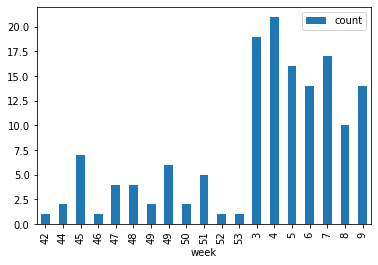

In [13]:
data_clear.plot(kind='bar', x='week', y='status')

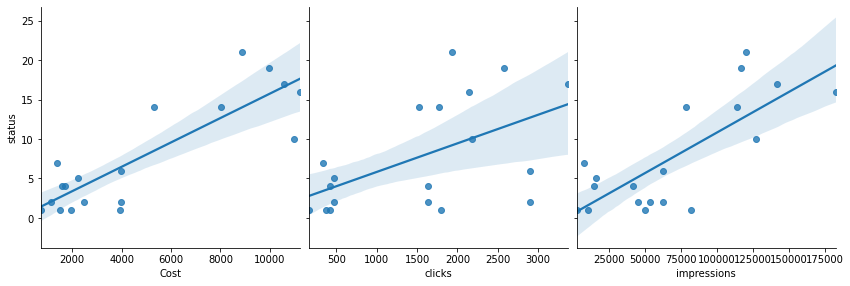

In [14]:
sns.pairplot(data_clear, x_vars=['Cost', 'clicks', 'impressions'], y_vars='status', height=4,kind='reg')

plt.show()

<AxesSubplot:>

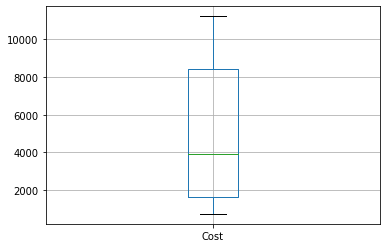

In [15]:
data_clear.boxplot('Cost')

<AxesSubplot:>

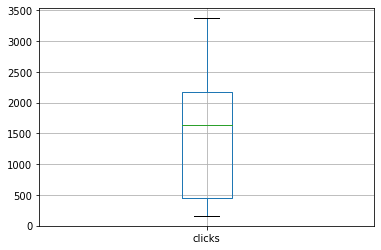

In [16]:
data_clear.boxplot('clicks')

<AxesSubplot:>

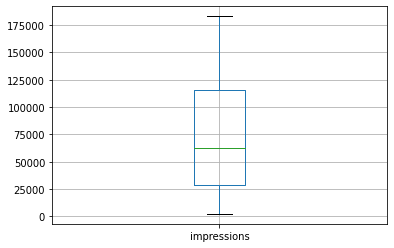

In [17]:
data_clear.boxplot('impressions')

In [18]:
data_zscore = data_clear

In [19]:
from scipy.stats import zscore

data_zscore['zscore_cost'] = zscore(data_zscore.Cost, ddof=0)
data_zscore['zscore_click'] = zscore(data_zscore.clicks, ddof=0)
data_zscore['zscore_impresstion'] = zscore(data_zscore.impressions, ddof=0)
data_zscore

<ipython-input-19-0849bba689de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_zscore['zscore_cost'] = zscore(data_zscore.Cost, ddof=0)


,week,status,Cost,clicks,impressions,zscore_cost,zscore_click,zscore_impresstion
,,count,sum,sum,sum,,,
0,42,1,1950.53,158.0,49977.0,-0.772206,-1.379730,-0.396370
1,44,2,1131.68,475.0,44948.0,-0.992790,-1.060319,-0.496007
2,45,7,1380.95,336.0,7352.0,-0.925641,-1.200376,-1.240877
3,46,1,1501.54,370.0,10511.0,-0.893156,-1.166118,-1.178289
4,47,4,1585.33,420.0,14264.0,-0.870584,-1.115737,-1.103933
5,48,4,1693.97,1637.0,41693.0,-0.841319,0.110518,-0.560496
6,49,2,3969.13,2897.0,62609.0,-0.228427,1.380101,-0.146098
7,49,6,3969.13,2897.0,62609.0,-0.228427,1.380101,-0.146098
8,50,2,2468.21,1638.0,53512.0,-0.632751,0.111526,-0.326333


In [20]:
threshold = 2.5

data_zscore['outlier_cost'] = data_zscore.zscore_cost.apply(lambda x : (np.abs(x) >= threshold) )
data_zscore['outlier_click'] = data_zscore.zscore_cost.apply(lambda x : (np.abs(x) >= threshold) )
data_zscore['outlier_impresstion'] = data_zscore.zscore_cost.apply(lambda x : (np.abs(x) >= threshold) )
data_clear

,week,status,Cost,clicks,impressions,zscore_cost,zscore_click,zscore_impresstion,outlier_cost,outlier_click,outlier_impresstion
,,count,sum,sum,sum,,,,,,
0,42,1,1950.53,158.0,49977.0,-0.772206,-1.379730,-0.396370,False,False,False
1,44,2,1131.68,475.0,44948.0,-0.992790,-1.060319,-0.496007,False,False,False
2,45,7,1380.95,336.0,7352.0,-0.925641,-1.200376,-1.240877,False,False,False
3,46,1,1501.54,370.0,10511.0,-0.893156,-1.166118,-1.178289,False,False,False
4,47,4,1585.33,420.0,14264.0,-0.870584,-1.115737,-1.103933,False,False,False
5,48,4,1693.97,1637.0,41693.0,-0.841319,0.110518,-0.560496,False,False,False
6,49,2,3969.13,2897.0,62609.0,-0.228427,1.380101,-0.146098,False,False,False
7,49,6,3969.13,2897.0,62609.0,-0.228427,1.380101,-0.146098,False,False,False
8,50,2,2468.21,1638.0,53512.0,-0.632751,0.111526,-0.326333,False,False,False


In [21]:
data_clear.describe()

,week,status,Cost,clicks,impressions,zscore_cost,zscore_click,zscore_impresstion
,,count,sum,sum,sum,,,
count,19.000000,19.000000,19.000000,19.000000,19.000000,1.900000e+01,1.900000e+01,1.900000e+01
mean,32.526316,7.736842,4817.092632,1527.315789,69983.052632,1.460820e-18,6.861288e-17,3.798131e-17
std,21.014197,6.910878,3813.898027,1019.647491,51856.305707,1.027402e+00,1.027402e+00,1.027402e+00
min,3.000000,1.000000,738.270000,158.000000,2330.000000,-1.098769e+00,-1.379730e+00,-1.340375e+00
25%,7.500000,2.000000,1639.650000,444.000000,28701.000000,-8.559516e-01,-1.091555e+00,-8.179001e-01
50%,45.000000,5.000000,3927.640000,1638.000000,62609.000000,-2.396041e-01,1.115260e-01,-1.460983e-01
75%,49.000000,14.000000,8449.600000,2166.500000,115400.000000,9.785386e-01,6.440455e-01,8.998226e-01
max,53.000000,21.000000,11230.470000,3372.000000,182956.000000,1.727660e+00,1.858714e+00,2.238275e+00


In [22]:
data_x = data_clear[['Cost', 'clicks', 'impressions']]
data_y = data_clear.status

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y)

In [24]:
lr = LinearRegression().fit(data_x, data_y)
lr.score(data_x, data_y)

0.7485337689767402

In [25]:
lr.coef_ , lr.intercept_  # m and b

(array([[ 2.23080164e-03, -8.07103720e-04, -4.12368817e-05]]),
 array([1.10944909]))

In [26]:
pre_data = lr.predict([[15000, 1500, 50000],
                       [20000, 2000, 70000],
                       [30000, 2500, 75000],
                       [50000, 3000, 80000]])

In [27]:
pre_data

array([[ 31.298974  ],
       [ 41.22469269],
       [ 62.92297281],
       [106.9292693 ]])

In [28]:
col_name = data_clear.columns.to_list()
data = data_clear[col_name[:5]]


In [29]:
data.columns = data.columns.droplevel(1)

In [30]:
data.to_sql("lead_progress", engine, if_exists="replace", index=False)
data.columns.to_list()
data

,week,status,Cost,clicks,impressions
0,42,1,1950.53,158.0,49977.0
1,44,2,1131.68,475.0,44948.0
2,45,7,1380.95,336.0,7352.0
3,46,1,1501.54,370.0,10511.0
4,47,4,1585.33,420.0,14264.0
5,48,4,1693.97,1637.0,41693.0
6,49,2,3969.13,2897.0,62609.0
7,49,6,3969.13,2897.0,62609.0
8,50,2,2468.21,1638.0,53512.0
9,51,5,2218.27,466.0,15709.0


In [31]:
cost_data_x = data[['Cost']]
imp_data_y = data.impressions
X_train, X_test, y_train, y_test = train_test_split(cost_data_x, imp_data_y, train_size=0.7)

In [32]:
imp_lr = LinearRegression().fit(X_train, y_train)
imp_lr.score(X_test, y_test)

0.9022649916855223

In [33]:
imp_lr.coef_ , imp_lr.intercept_  # m and b

(array([13.10912885]), 11242.749048095262)

In [67]:
click_data_x = data[['Cost', 'impressions']]
click_data_y = data.clicks
X_train, X_test, y_train, y_test = train_test_split(click_data_x, click_data_y, train_size=0.7)

In [68]:
cli_lr = LinearRegression().fit(X_train, y_train)
cli_lr.score(X_test, y_test)

0.6356079105386732

In [69]:
cli_lr.coef_ , cli_lr.intercept_  # m and b

(array([0.07454984, 0.00695676]), 591.6464584183815)

In [70]:
imp_values = [[15000],[20000],[30000],[50000]]

In [71]:
imp_pre = imp_lr.predict(imp_values)
imp_pre

array([207879.68174984, 273425.32598375, 404516.61445158, 666699.19138724])

In [72]:
cl_data = [[imp_values[i][0], imp_pre[i]] for i in range(len(imp_values))]
cl_data

[[15000, 207879.68174983922],
 [20000, 273425.3259837539],
 [30000, 404516.6144515832],
 [50000, 666699.1913872419]]

In [73]:
cli_pre = cli_lr.predict(cl_data)
cli_pre

array([3156.06384547, 3984.79859297, 5642.26808796, 8957.20707795])

In [74]:
lead_data = [[imp_values[i][0], cli_pre[i] ,imp_pre[i]]for i in range(len(imp_values))]
lead_data

[[15000, 3156.063845468552, 207879.68174983922],
 [20000, 3984.798592966108, 273425.3259837539],
 [30000, 5642.26808796122, 404516.6144515832],
 [50000, 8957.207077951445, 666699.1913872419]]

In [75]:
lead_pre = lr.predict(lead_data)
lead_pre

array([[23.45189294],
       [31.23412825],
       [46.79859888],
       [77.92754013]])